# **PROJET ACCIDENTOLOGIE USAGERS : KAGGLE ESIEE 2023 - 2024**

# **OUVERTURE DES FICHIERS**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
pd.set_option('display.max_columns', None)

In [44]:
def open_file(item):
    # Création d'un DataFrame vide pour accumuler les données
    all_data = pd.DataFrame()

    # Boucle sur chaque année
    for annee in range(2012, 2023):
        path = f"TRAIN/BAAC-Annee-{annee}/{item}_{annee}_.csv"
        try:
            # Lecture du fichier CSV
            file = pd.read_csv(path, delimiter=';', index_col = 0,low_memory=False)
            # Concaténation du fichier lu avec le DataFrame global
            all_data = pd.concat([all_data, file])
        except FileNotFoundError:
            print(f"Le fichier {path} n'a pas été trouvé.")
        except Exception as e:
            print(f"Erreur lors de la lecture du fichier {path}: {e}")

    return all_data

In [45]:
def create_dataframe():

    caracteristiques = open_file('caracteristiques')
    lieux = open_file('lieux')
    usagers = open_file('usagers')
    vehicules = open_file('vehicules')

    return caracteristiques,lieux,usagers,vehicules

In [46]:
caracteristiques,lieux,usagers,vehicules = create_dataframe()

### **Isolation de la colonne Grave**

In [47]:
# Convertir la colonne 'grav' en array numpy
grav_array = usagers['grav'].values
num_acc_array = usagers['Num_Acc'].values

# Créer un array pour la présence de 'GRAVE'
is_grave = np.isin(grav_array, [2, 3])

# Utiliser ufuncs de numpy pour créer un mapping de 'Num_Acc' à 'GRAVE'
unique_nums, grave_presence = np.unique(num_acc_array, return_inverse=True)
result = np.bitwise_or.reduceat(is_grave, np.r_[0, np.where(np.diff(num_acc_array))[0]+1])

In [48]:
usagers.drop('grav',axis = 1,inplace = True)

In [49]:
# Création du DataFrame
df_grave = pd.DataFrame({
    'Num_Acc': unique_nums,
    'GRAVE': result
})

df_grave['GRAVE'] = df_grave['GRAVE'].astype(int)

### **Merge GRAVE + Dataframe :** 

In [50]:
def merge_grave(df):

    return df_grave.merge(df,on = "Num_Acc",how = 'left')

### **Fonction Analyse :**

In [51]:
def summary_info(df):

    # Créer un nouveau DataFrame avec ces comptages
    return  pd.DataFrame({
        'NaN_Count': df.isna().sum().astype(int),
        'Nan_ratio': df.isna().mean().astype(float),
        '-1_Count': df.eq(-1).sum().astype(int),
        '0_Count': df.eq(0).sum().astype(int)
    })

In [52]:
caracteristiques = merge_grave(caracteristiques)

## **ANALYSE USAGERS :**

In [53]:
def caracteristiques_del_(df):

    col_to_drop = ['adr','lat','long']
    df = df.drop(col_to_drop,axis = 1)

    return df

In [54]:
def caracteristiques_NaN_(df):

    col_to_replace = ['atm','col','gps']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)
    
    return df

In [55]:
def caracteristiques_correction_(df):

    df['int'] = df['int'].replace(0,-1)

    return df

In [56]:
def adjust_year(year):
    if year < 100:  # Supposons que toute valeur < 100 représente les deux derniers chiffres de l'année
        return 2000 + year
    else:
        return year

In [57]:
def convert_time_to_minutes(time_str):
    # S'assurer que toutes les entrées sont des chaînes de caractères
    time_str = str(time_str)
    
    if ':' in time_str:  # Format HH:MM
        hours, minutes = map(str, time_str.split(':'))
        return int(hours + minutes)
    else:  # Format en nombre entier représentant des minutes ou des horaires comme '1800' qui signifie 18:00
        time_str = time_str.zfill(4)  # Assure que la chaîne a au moins 4 caractères (par ex. '533' devient '0533')
        hours = str(time_str[:2])
        minutes = str(time_str[2:])
        return int(hours + minutes)
    
def processing_hrmn(df):

    df['hrmn'] = df['hrmn'].apply(convert_time_to_minutes)
    df['hrmn'] = df['hrmn'].apply(lambda x: round(x / 100) * 100)

    return df

In [58]:
def clean_dep(dep, an):
    if an <= 2018 and dep not in [201, 202, 972, 973, 974, 976]:
        return int(dep) // 10

    return dep

def preprocessing_dep(df):

    df['dep'] = df['dep'].replace('2B',201)
    df['dep'] = df['dep'].replace('2A',202)
    df['dep'] = df.apply(lambda row: clean_dep(row['dep'], row['an']), axis=1)

    return df

In [59]:
def caracteristiques_preprocessing_(df):

    df = caracteristiques_del_(df)
    df = caracteristiques_NaN_(df)
    df = caracteristiques_correction_(df)

    df['an'] = df['an'].apply(adjust_year)
    df = processing_hrmn(df)
    df = preprocessing_dep(df)

    category_columns = ['lum','agg','int','atm','col','dep']
    df[['an','jour','mois','hrmn']] = df[['an','jour','mois','hrmn']].astype(int)
    df[category_columns] = df[category_columns].astype(int)

    category_columns.append('gps')
    category_columns.append('com')

    df[category_columns] = df[category_columns].astype('category')

    return df

In [60]:
caracteristiques_naive = caracteristiques_preprocessing_(caracteristiques)

In [61]:
summary_info(caracteristiques_naive).T.head()

,Num_Acc,GRAVE,an,mois,jour,hrmn,lum,agg,int,atm,col,com,gps,dep
NaN_Count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nan_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1_Count,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,89.0,68.0,1451.0,0.0,313454.0,0.0
0_Count,0.0,339307.0,0.0,0.0,0.0,9576.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **TRAINING MODEL :**

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X = caracteristiques_naive.drop(['Num_Acc','GRAVE'],axis = 1)
y = caracteristiques_naive['GRAVE']

In [64]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [65]:
def importance_values(feature_imp_df):

    # Visualisation avec un graphique à barres
    plt.figure(figsize=(10, 6))
    plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Variables')
    plt.title('Importance des variables dans le modèle LightGBM')
    plt.gca().invert_yaxis()  # Inverser l'axe y pour avoir la variable la plus importante en haut
    plt.show()

In [66]:
def loss_curve(evals_result):

    # Extraction des scores L1 pour les ensembles de train et de test
    train_l1 = evals_result['training']['l1']
    test_l1 = evals_result['valid_1']['l1']

    # Création du graphique
    plt.figure(figsize=(10, 6))
    plt.plot(train_l1, label='Train')
    plt.plot(test_l1, label='Test')
    plt.title('Courbe d\'apprentissage du modèle LightGBM')
    plt.xlabel('Nombre d\'itérations')
    plt.ylabel('L1 Loss')
    plt.legend()
    plt.show()

In [67]:
def auc_curve(evals_result):

    train_auc = evals_result['training']['auc']
    test_auc = evals_result['valid_1']['auc']

    # Graphique pour AUC
    plt.figure(figsize=(10, 6))
    plt.plot(train_auc, label='Train AUC')
    plt.plot(test_auc, label='Test AUC')
    plt.title('Évolution de l\'AUC au fil des itérations')
    plt.xlabel('Nombre d\'itérations')
    plt.ylabel('AUC')
    plt.legend()

In [68]:
def training_model(model,X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    evals_result = {}

    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric=['auc', 'l1'])

    y_pred_proba_lgb = model.predict_proba(X_test)[:, 1]
    auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
    print("AUC LightGBM:", auc_lgb)

    # Extraction des importances des variables
    feature_importances = model.feature_importances_

    evals_result = model.evals_result_

    feature_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    importance_values(feature_imp_df)
    loss_curve(evals_result)
    auc_curve(evals_result)

    return feature_imp_df

In [69]:
lgb_model = lgb.LGBMClassifier(enable_categorical = True,learning_rate = 0.01,verbose = -1,n_estimators = 200,objective='binary')

In [70]:
feature_imp_df = training_model(lgb_model,X,y)

# **FEATURE ENGINEERING :**

In [71]:
def feature_engineering(df):

    df = caracteristiques_preprocessing_(df)
    
    return df

In [72]:
caracteristiques_fe = feature_engineering(caracteristiques)

# **TRAINING MODEL USAGERS :**

In [73]:
X = caracteristiques_fe.drop(['Num_Acc','GRAVE'],axis = 1)
y = caracteristiques_fe['GRAVE']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

AUC LightGBM: 0.8131705573732342


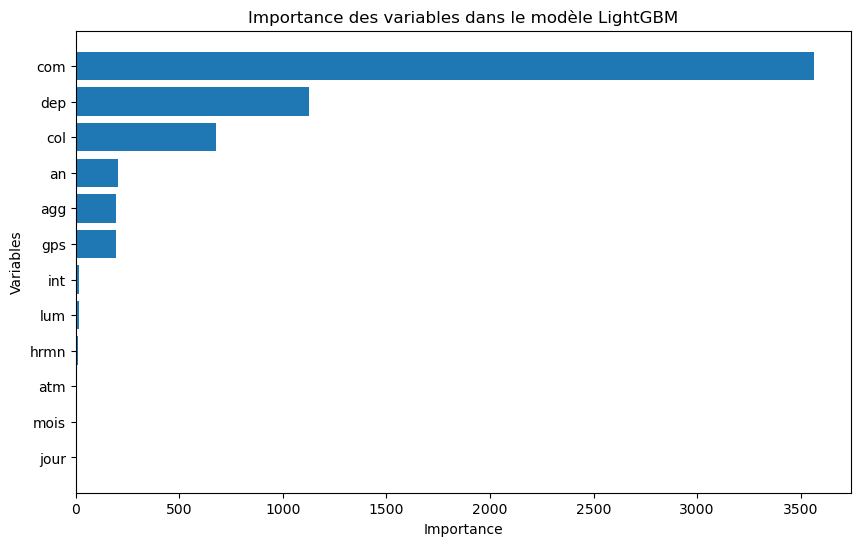

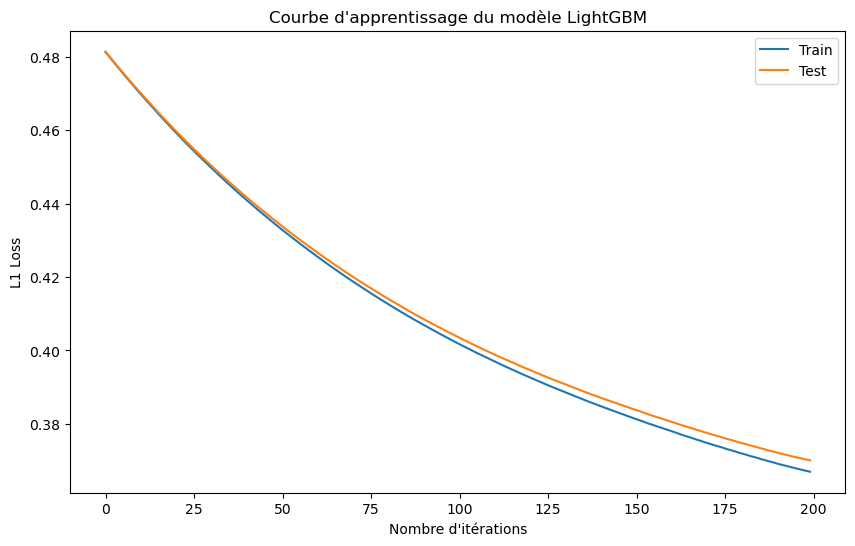

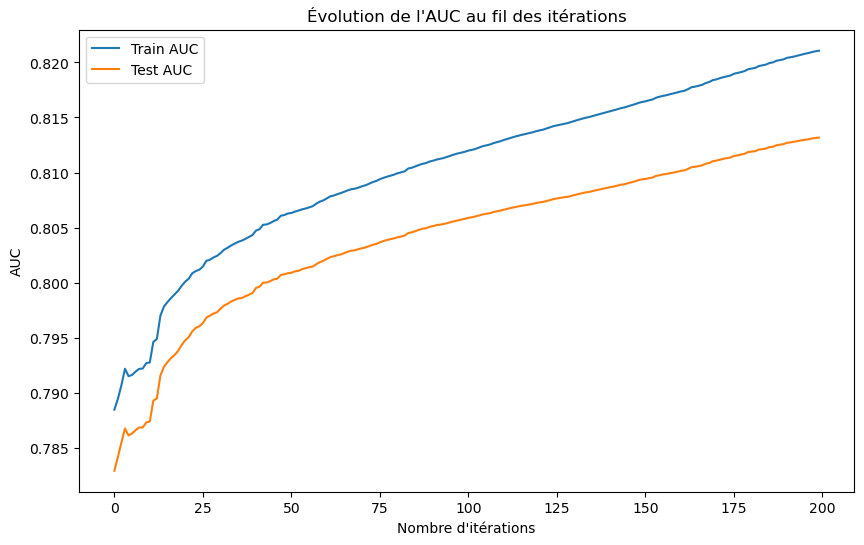

In [75]:
feature_imp_df = training_model(lgb_model,X,y)

In [76]:
feature_imp_df.T

,9,11,8,0,5,10,6,4,3,7,1,2
Feature,com,dep,col,an,agg,gps,int,lum,hrmn,atm,mois,jour
Importance,3564,1125,678,202,194,192,17,14,11,3,0,0


In [77]:
caracteristiques_fe_clean = caracteristiques_fe.copy()

In [78]:
best_features = feature_imp_df[feature_imp_df['Importance'] > 50]

In [79]:
X = caracteristiques_fe_clean[best_features['Feature'].to_list()]
y = caracteristiques_fe_clean['GRAVE']

In [80]:
best_features.T

,9,11,8,0,5,10
Feature,com,dep,col,an,agg,gps
Importance,3564,1125,678,202,194,192


In [81]:
lgb_model = lgb.LGBMClassifier(enable_categorical = True,verbose = -1,objective='binary',learning_rate = 0.005,n_estimators = 800, num_leaves  = 25)

AUC LightGBM: 0.8189480427727615


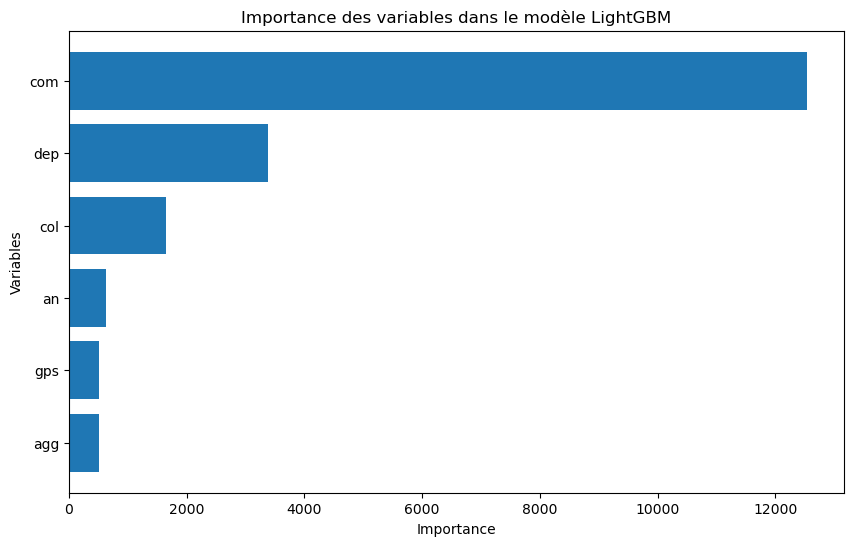

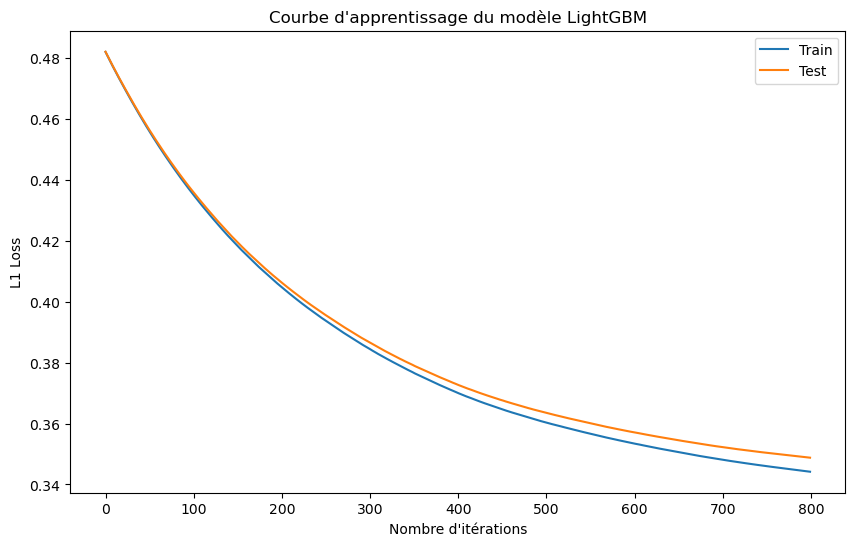

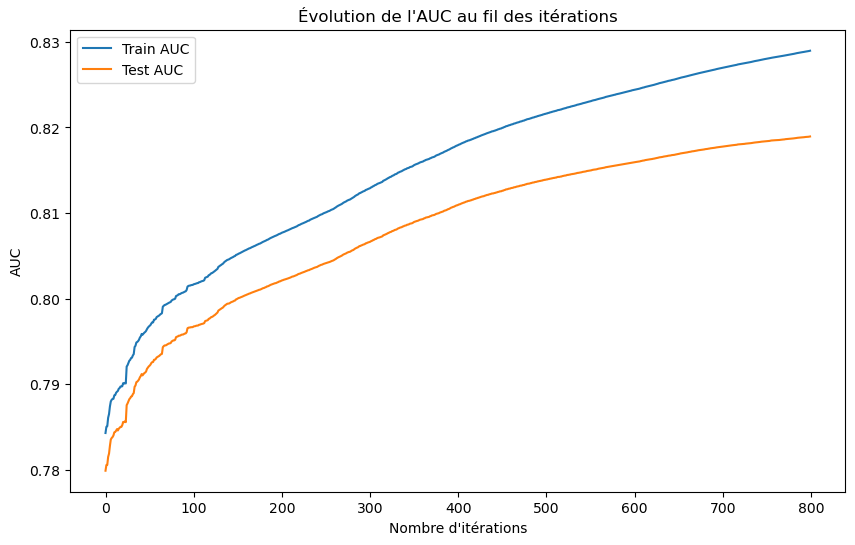

In [82]:
feature_imp_df_final = training_model(lgb_model,X,y)